## Introduction to Tasks with States

Task might be run for a single set of input values or we can generate multiple sets, that will be called "states". If we want to run our `Task` multiple times we have to provide an input that is an iterable and specify the way we want to map values of the inputs to the specific states. In order to do it, we set so-called `splitter`. 

Let's start from a simple `FunctionTask` that takes a list as an input:

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
import pydra

@pydra.mark.task
def add_two(x):
    return x + 2

task1 = add_two(x=[1, 2, 3])

If we try to run this it will error because a list and a scalar cannot be added in Python

In [ ]:
task1()

Now, we can set the `splitter` by using the `split` method. Since our task has only one input, there is only one option to create a set of inputs, i.e. `splitter="x"`:

In [ ]:
task1.split("x")

Now, we can run the task and check results:

In [ ]:
task1()
task1.result()

We can also return results together with values of the input, we just have to set an additional argument `return_inputs` to `True` (or `val`)

In [ ]:
task1.result(return_inputs=True)

For tasks with a state *pydra* prepare all sets of inputs and run the task for each of the set. We could simply represent this by the following figure:

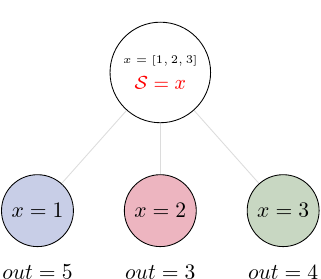

### Multiple inputs and state splitting

We can also use `State` for functions with multiple inputs:

In [ ]:
@pydra.mark.task
def add_var(a, b):
    return a + b

Now we have more options to define `splitter`, it depends on the type of inputs and on our application. For example, we could have `a` that is a list, `b` that is a single value, and split over `a` values:

In [ ]:
task2 = add_var(a=[1, 2, 3], b=10).split("a")
task2()
task2.result()

Now we have three results for each element from the `a` list and the value of `b` is always the same. 

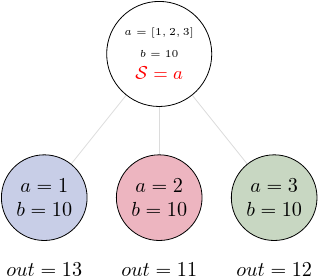

But we can have lists for both inputs, and use both inputs in the splitter. Let's assume that `a` and `b` are two elements lists.

In [ ]:
task3 = add_var(a=[1, 2], b=[10, 100])

Now, we have two options to map the input values, we might want to run the task for two sets of values: (`a`=1, `b`=10) and (`a`=2, `b`=100), or we might want to run the task for four sets: (`a`=1, `b`=10), (`a`=1, `b`=100), (`a`=2, `b`=10) and (`a`=2, `b`=100). 

**The first situation will be represented by the so-called "scalar" splitter, the later by the so-called "outer" splitter.**

#### Scalar splitter

Let's start from the scalar splitter, that uses parentheses in the syntax:

In [ ]:
task3.split(("a", "b"))
task3()
task3.result()

As we expected, we have two outputs: `1+10=11` and `2+100=102`. 

We can represent the execution by the graph:

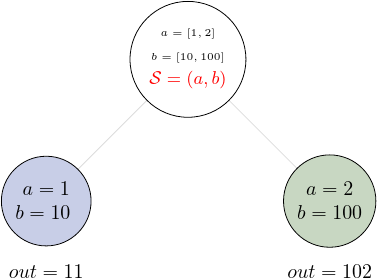

#### Outer splitter

For the outer splitter we will use brackets:

In [ ]:
task4 = add_var(a=[1, 2], b=[10, 100])
task4.split(["a", "b"])
task4()
task4.result()

Now, we have results for all of the combinations of values from `a` and `b`.

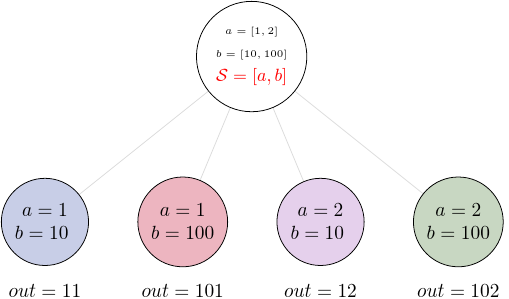

For more inputs we can create more complex splitter, and use scalar and outer splitters together. **Note, that the scalar splitter can only work for lists that have the same length, but the outer splitter doesn't have this limitation.** 

Let's run one more example that takes four inputs, `x` and `y` components of two vectors, and calculates all possible sums of vectors. `x` components should be kept together with corresponding `y` components (i.e. scalar splitters: `("x1", "y1")` and `("x2", "y2")`), but we should use outer splitter for two vectors to get all combinations.

In [ ]:
@pydra.mark.task
def add_vector(x1, y1, x2, y2):
    return (x1 + x2, y1 + y2)

task5 = add_vector(name="add_vect", output_names=["x", "y"], 
                   x1=[10, 20], y1=[1, 2], x2=[10, 20, 30], y2=[10, 20, 30])
task5.split(splitter=[("x1", "y1"), ("x2", "y2")])
task5()
task5.result()

We should get six outputs: two elements for vector1 times three elements for vector2.

### Combining the output

When we use `splitter`, we can also define `combiner`, if we want to combine together the results.

If we take the `task4` as an example and combine all results for each element of the input `b`, we can modify the task as follows:

In [ ]:
task5 = add_var(a=[1, 2], b=[10, 100])
task5.split(["a", "b"])
# adding combiner
task5.combine("b")
task5()
task5.result()

Now our result contains two elements, each one is a list. The first one contains results for `a=1` and both values of `b`, and the second contains results for `a=2` and both values of `b`. Let's print the result again using `return_inputs`:

In [ ]:
all_results = task5.result(return_inputs=True)
print(f"first list, a=1: {all_results[0]}")
print(f"\n second list, a=2: {all_results[1]}")

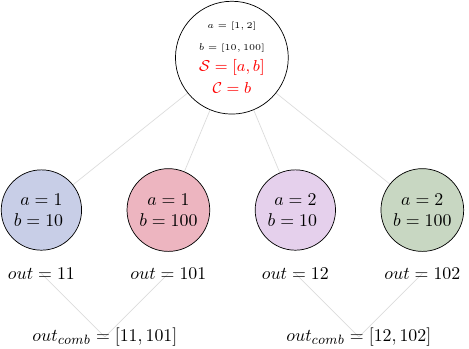

But we could also group all elements from the input `a` and have a different combined output:

In [ ]:
task6 = add_var(a=[1, 2], b=[10, 100])
task6.split(["a", "b"])
# changing the combiner
task6.combine("a")
task6()
task6.result()

We still have two elements in our results, but this time the first element contains results for `b=10` and both values of `a`, and the second contains results for `b=100` and both values of `a`.

In [ ]:
all_results = task5.result(return_inputs=True)
print(f"first list, b=10: {all_results[0]}")
print(f"\n second list, b=100: {all_results[1]}")

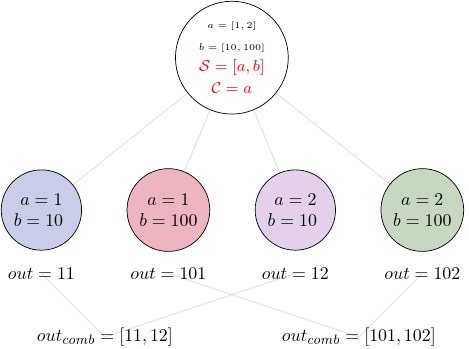

We can also combine all elements by providing a list of all inputs to the `combiner`:

In [ ]:
task7 = add_var(a=[1, 2], b=[10, 100])
task7.split(["a", "b"])
# combining all inputs
task7.combine(["a", "b"])
task7()
task7.result()

This time the output contains one element that is a list of all outputs:

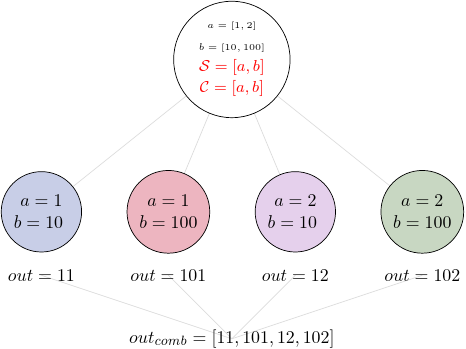

### Parallel execution

We run task multiple times for multiple sets of input, but we didn't talk about the execution time. Let's create a function that sleeps for a second and run for four values:

In [ ]:
import time

@pydra.mark.task
def add_two_sleep(x):
    time.sleep(1)
    return x + 2

task9 = add_two_sleep(x=[1, 2, 3, 4]).split("x")
t0 = time.time()
task9()
print(f'total time: {time.time() - t0}')
task9.result()

The total time will depend on the machine you are using, but it could be below `1.1s`, so clearly the tasks are running in parallel!

If we run `Task` that has a `State`, pydra will automatically create a `Submitter` with a default `Worker` that is `cf`, i.e. `ConcurrentFutures`.

We could also create a `Submitter` first, and than use it to run the task:

All of the execution time should be similar, since all taska are run by *pydra* in the same way, i.e. *pydra* creates a submitter with `ConcurrentFutures` worker, if a number of processors is not provided, `ConcurrentFutures` takes all available processors as `max_workers`. However, if we want to set a specific number of processors, we can set it using `n_procs` when creating a `Submitter`. Let's see how the execution time changes when we use `n_procs=2`.


In [ ]:
task13 = add_two_sleep(x=[1, 2, 3, 4]).split("x")

t0 = time.time()
with pydra.Submitter(plugin="cf", n_procs=2) as sub:
    sub(runnable=task13)
print(f'total time: {time.time() - t0}')
print(f"results: {task13.result()}")


Now, the total time could be significantly different. For example, if your machine has at least 4 processors, the previous `tasks9` - `task12` took around 1s to run, but the task13 took around 2s.
If you have 2 processors or less, you should not see any difference in the execution time.